# 2. Splitting a Pytorch dataset into unbalanced partitions
Author: Javier Sales-Ortiz

Date: Nov, 2022

CMPUT 644 Final project

In [1]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import numpy as np 
import matplotlib.pyplot as plt

from flwr.common import Metrics

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST 
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torchsummary import summary

# For function
from partition import *

In [2]:
np.set_printoptions(edgeitems=30, linewidth=100000)

In [3]:
# Root dir for FashionMNIST
root = '../../data'

In [4]:
# Get cpu or gpu device for training.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {DEVICE} device")

NUM_CLIENTS = 10

BATCH_SIZE = 64


transform = transforms.Compose(
[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load in the Fashion MNIST dataset
training_data = FashionMNIST(
    root=root,
    train=True,
    download=True,
    transform=transform
)

print("\nType and dir of training_data")
print(type(training_data))
#print(dir(training_data))

print("\ntraining_data.train_data")
print(type(training_data.train_data))
print(training_data.train_data.shape)

print("\ntraining_data.train_labels")
print(type(training_data.train_labels))
print(training_data.train_labels.shape)



test_data = FashionMNIST(
    root=root,
    train=False,
    download=True,
    transform=transform
)

print("\nType and dir of test_data")
print(type(test_data))
print(dir(test_data))

print("\ntest_data.test_data")
print(type(test_data.test_data))
print(test_data.test_data.shape)

print("\ntest_data.test_labels")
print(type(test_data.test_labels))
print(test_data.test_labels.shape)

# Split the training data into NUM_CLIENTS clients
partition_size = len(training_data) // NUM_CLIENTS
lengths = [partition_size] * NUM_CLIENTS
datasets = random_split(training_data, lengths, generator=torch.Generator().manual_seed(42))

Using cpu device

Type and dir of training_data
<class 'torchvision.datasets.mnist.FashionMNIST'>

training_data.train_data
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])

training_data.train_labels
<class 'torch.Tensor'>
torch.Size([60000])

Type and dir of test_data
<class 'torchvision.datasets.mnist.FashionMNIST'>
['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 

/home/javier/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/javier/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/javier/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/javier/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Train data to numpy 
Do some analysis

In [5]:
np_train_labels = training_data.train_labels.cpu().detach().numpy()
np_train_data = training_data.train_data.cpu().detach().numpy()

print(type(np_train_labels))
print(np_train_labels.shape)

lunique, lcount = np.unique(np_train_labels, return_counts = True)
print(lunique, lcount)
i = 0

<class 'numpy.ndarray'>
(60000,)
[0 1 2 3 4 5 6 7 8 9] [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


In [6]:
np_test_labels = test_data.test_labels.cpu().detach().numpy()
print(type(np_test_labels))
lunique, lcount = np.unique(np_test_labels, return_counts = True)
print(lunique, lcount)

<class 'numpy.ndarray'>
[0 1 2 3 4 5 6 7 8 9] [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


9
type(np_train_labels)=<class 'numpy.ndarray'>
type(np_train_data)=<class 'numpy.ndarray'>
type(img)=<class 'numpy.ndarray'>


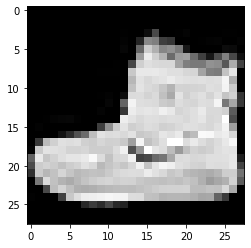

In [7]:
print(np_train_labels[i])
img = np_train_data[i]
print(f"{type(np_train_labels)=}")
print(f"{type(np_train_data)=}")
print(f"{type(img)=}")
plt.imshow(img, cmap='gray')
i+=1

In [8]:
print(f'{type(np_train_data)=}')
print(f'{np_train_data.shape=}')
print(f'{type(np_train_labels)=}')
print(f'{np_train_labels.shape=}')
print(f'{np.expand_dims(np_train_labels, axis=(1,2)).shape=}')

type(np_train_data)=<class 'numpy.ndarray'>
np_train_data.shape=(60000, 28, 28)
type(np_train_labels)=<class 'numpy.ndarray'>
np_train_labels.shape=(60000,)
np.expand_dims(np_train_labels, axis=(1,2)).shape=(60000, 1, 1)


## Try function that returns just the indices

In [9]:
# Test unbal_idx
N = 5
M = 50
art_labels = np.arange(0,N).repeat(M// N)
print(art_labels)
print(len(art_labels))
lengths = [M//N]*N
    
Ic = unbal_idx(art_labels, N, 0.6)
for i, cli in enumerate(Ic):
    print(f"Client {i}: {cli}")
[art_labels[Ii] for Ii in Ic]

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4]
50
Client 0: [6, 3, 7, 8, 5, 2, 17, 12, 20, 35]
Client 1: [19, 10, 18, 16, 13, 11, 24, 29, 37, 46]
Client 2: [1, 23, 27, 22, 25, 21, 28, 33, 36, 44]
Client 3: [9, 15, 34, 30, 32, 38, 39, 31, 49, 40]
Client 4: [0, 4, 14, 26, 47, 41, 45, 42, 43, 48]


[array([0, 0, 0, 0, 0, 0, 1, 1, 2, 3]),
 array([1, 1, 1, 1, 1, 1, 2, 2, 3, 4]),
 array([0, 2, 2, 2, 2, 2, 2, 3, 3, 4]),
 array([0, 1, 3, 3, 3, 3, 3, 3, 4, 4]),
 array([0, 0, 1, 2, 4, 4, 4, 4, 4, 4])]

## Try with Pytorch dataset

In [12]:
NUM_CLIENTS = 10
partition_size = len(training_data) // NUM_CLIENTS
lengths = [partition_size] * NUM_CLIENTS
# Try with p=0.6 for sum is less, try with p=0.8 for uneven lengths
datasets = unbal_split(training_data, lengths, p=0.8, generator=torch.Generator().manual_seed(43))

### Visualize partitions

In [13]:
dict_fashion = {0: "T-shirt/top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle boot",
               }

for i, ds in enumerate(datasets):
    print("Client:", i, type(ds))
    #print(dir(ds))
    #print(dir(ds.dataset))
    #print(dir(ds.indices))
    
    np_client_labels = ds.dataset.train_labels[ds.indices].cpu().detach().numpy()
    np_client_data   = ds.dataset.train_data[ds.indices].cpu().detach().numpy()
    lunique, lcounts = np.unique(np_client_labels, return_counts = True)
    lcountsn = np.divide(lcounts, lcounts.sum())
    print(lunique)
    print(lcountsn.round(3), "=", lcounts.sum())
    print()
    for j in np.linspace(0, partition_size-1, num=10).astype(int):
        print(np_client_labels[j], ":", dict_fashion[np_client_labels[j]])
        plt.imshow(np_client_data[j])
        plt.show()
        
    #break

Client: 0 <class 'torch.utils.data.dataset.Subset'>
[0 1 2 3 4 5 6 7 8 9]
[0.8   0.119 0.039 0.018 0.01  0.006 0.004 0.003 0.002 0.001] = 6000

Client: 1 <class 'torch.utils.data.dataset.Subset'>
[0 1 2 3 4 5 6 7 8 9]
[0.001 0.8   0.119 0.039 0.018 0.01  0.006 0.004 0.003 0.002] = 6000

Client: 2 <class 'torch.utils.data.dataset.Subset'>
[0 1 2 3 4 5 6 7 8 9]
[0.002 0.001 0.8   0.119 0.039 0.018 0.01  0.006 0.004 0.003] = 6000

Client: 3 <class 'torch.utils.data.dataset.Subset'>
[0 1 2 3 4 5 6 7 8 9]
[0.003 0.002 0.001 0.8   0.119 0.039 0.018 0.01  0.006 0.004] = 6000

Client: 4 <class 'torch.utils.data.dataset.Subset'>
[0 1 2 3 4 5 6 7 8 9]
[0.004 0.003 0.002 0.001 0.8   0.119 0.039 0.018 0.01  0.006] = 6000

Client: 5 <class 'torch.utils.data.dataset.Subset'>
[0 1 2 3 4 5 6 7 8 9]
[0.006 0.004 0.003 0.002 0.001 0.8   0.119 0.039 0.018 0.01 ] = 6000

Client: 6 <class 'torch.utils.data.dataset.Subset'>
[0 1 2 3 4 5 6 7 8 9]
[0.01  0.006 0.004 0.003 0.002 0.001 0.8   0.119 0.039 0.018] 

## Jihoon's code, here to test if it runs

In [18]:
def load_datasets():
    # Define the transformation to Fashion MNIST
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    
    # Load in the Fashion MNIST dataset
    training_data = FashionMNIST(
        root=root,
        train=True,
        download=True,
        transform=transform
    )
    
    
    test_data = FashionMNIST(
        root=root,
        train=False,
        download=True,
        transform=transform
    )
    

    # Split the training data into NUM_CLIENTS clients
    partition_size = len(training_data) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = unbal_split(training_data, lengths, p=0.6, generator=torch.Generator().manual_seed(42))
    #datasets = random_split(training_data, lengths, generator=torch.Generator().manual_seed(42))
    #print(datasets)
    
    # Split each partition into train.val and create DataLoader
    train_loaders = []
    val_loaders = []
    for i, ds in enumerate(datasets):
        print(i)
        length_val = len(ds) // 10 # 10% of the partition is used for validation
        length_train = len(ds) - length_val
        lengths = [length_train, length_val]
        ds_train, ds_val = random_split(ds, lengths, generator=torch.Generator().manual_seed(42))
        train_loaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        val_loaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    return train_loaders, val_loaders, test_loader

train_loaders, val_loaders, test_loader = load_datasets()

0
1
2
3
4
5
6
7
8
9


In [40]:
glabels = []
for loaders in [train_loaders]: #, val_loaders]:
    for loader in loaders:
        for images, labels in loader:
            for l in labels:
                glabels.append(l.item())
            

print(glabels[:2])
nlabels = np.array(glabels)
labels, lcount = np.unique(nlabels, return_counts = True)
print(labels)
print(lcount, " = ", lcount.sum())
print(type(datasets))
print(type(datasets[0]))

[0, 2]
[0 1 2 3 4 5 6 7 8 9]
[5439 5418 5401 5398 5388 5403 5384 5389 5386 5394]  =  54000
<class 'list'>
<class 'torch.utils.data.dataset.Subset'>


In [ ]:
def train(net, train_loader, epochs: int, verbose=False):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss 
            total += labels.size(0)
            correct += (torch.max(outputs, 1)[1] == labels).sum().item()
        epoch_loss /= len(train_loader.dataset)
        epoch_acc = correct / total

        if verbose:
            print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")   

def test(net, test_loader):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        loss /= len(test_loader.dataset)
        accuracy = correct / total

        return loss, accuracy

def modelA():
    model = nn.Sequential(
        nn.Conv2d(1,64,(5,5), padding='valid'),
        nn.ReLU(),
        nn.Conv2d(64,64,(5,5)),
        nn.ReLU(),
        nn.Dropout2d(0.25),
        nn.Flatten(),
        nn.Linear(25600,128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128,10),
    )
    return model

def modelB():
    model = nn.Sequential(
        nn.Dropout2d(0.2),
        nn.Conv2d(1,64,(8,8), padding=(3,3), stride=(2,2)),
        nn.ReLU(),
        nn.Conv2d(64,128,(6,6), padding='valid', stride=(2,2)),
        nn.ReLU(),
        nn.Conv2d(128,128,(5,5), stride=(1,1)),
        nn.ReLU(),
        nn.Dropout2d(0.5),
        nn.Flatten(),
        nn.Linear(128,10),
    )
    return model

def modelC():
    model = nn.Sequential(
        nn.Conv2d(1,128,(3,3), padding='valid'),
        nn.ReLU(),
        nn.Conv2d(128,64,(3,3)),
        nn.ReLU(),
        nn.Dropout2d(0.25),
        nn.Flatten(),
        nn.Linear(36864,128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128,10)
    )
    return model

def modelD():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 300),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(300, 300),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(300, 300),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(300, 300),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(300, 10),
    )

    return model

def modelE():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
    )

    return model

def modelF():
    model = nn.Sequential(
        nn.Conv2d(1, 32, (5,5,), padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Conv2d(32, 64, (5,5)),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )

    return model

def modelG():
    model = nn.Sequential(
        nn.Conv2d(1, 32, (5,5), padding='same'),
        nn.ReLU(),
        nn.Conv2d(32, 32, (5,5), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Dropout2d(0.25),
        nn.Conv2d(32, 64, (3,3), padding='same'),
        nn.ReLU(),
        nn.Conv2d(64, 64, (3,3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride=(2,2)),
        nn.Dropout2d(0.25),
        nn.Flatten(),
        nn.Linear(3136, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, 10)
    )

    return model

def ModelLR():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 10),
    )

    return model



def get_parameters(net) -> List[np.ndarray]:
    """Get model parameters as a list of NumPy ndarrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]) -> None:
    """Set model parameters from a list of NumPy ndarrays."""
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, train_loader, val_loader):
        self.net = net 
        self.train_loader = train_loader
        self.val_loader = val_loader

    def get_parameters(self, config):
        return get_parameters(self.net)
    
    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.train_loader, epochs=10)
        return get_parameters(self.net), len(self.train_loader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.val_loader)
        return float(loss), len(self.val_loader), {"accuracy": float(accuracy)}

def client_fn(cid: str) -> FlowerClient:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = modelA().to(DEVICE)
    return FlowerClient(net, train_loaders[int(cid)], val_loaders[int(cid)])

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

stragegy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # Custom aggregation function
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=stragegy
)




INFO flower 2022-11-08 13:57:24,456 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2022-11-08 13:57:24,739	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-11-08 13:57:26,018 | app.py:174 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3120210739.0, 'CPU': 8.0, 'node:192.168.0.12': 1.0, 'memory': 6240421479.0}
INFO flower 2022-11-08 13:57:26,019 | server.py:86 | Initializing global parameters
INFO flower 2022-11-08 13:57:26,020 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-11-08 13:57:27,216 | server.py:274 | Received initial parameters from one random client
INFO flower 2022-11-08 13:57:27,216 | server.py:88 | Evaluating initial parameters
INFO flower 2022-11-08 13:57:27,217 | server.py:101 | FL starting
DEBUG flower 2022-11-08 13:57:27,217 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-11-08 14:12:34,048 | s